# Applying strain to FBG and calculate cross-correlation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from fbg import *
from scipy.signal import find_peaks

In [3]:
filepath = 'spectra_files/psg_trn.txt'
data = psg_to_numpy(filepath, verbose=False)

For this demo, we'll be working with Methane. 

We'll look at the spectrum in the wavelength between 1620 and 1665nm, because this is where the spectrum is cleanest and the absorption lines are strong and periodic.

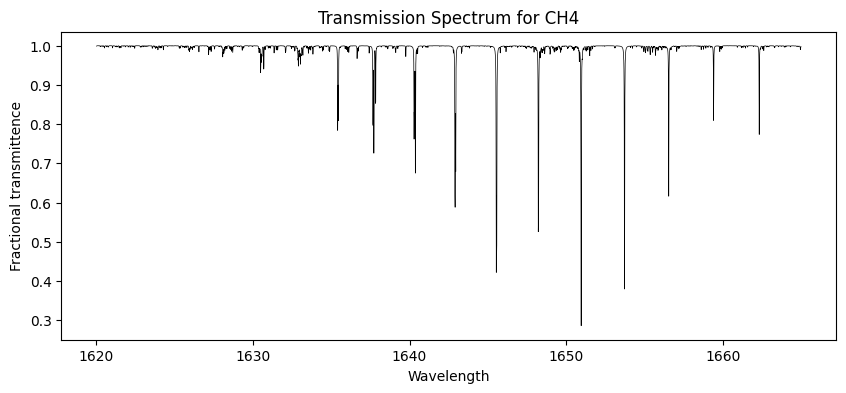

In [10]:
wavelength = data[:,0]*1e3 # converts units to nm
index =  np.where((wavelength>1620) & (wavelength<=1665))[0] # look at a small subset of the data

plt.figure(figsize=(10,4))
plt.plot(wavelength[index], data[index, 1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.show()

Locate peaks with minimal distance between peaks to eliminate split peaks

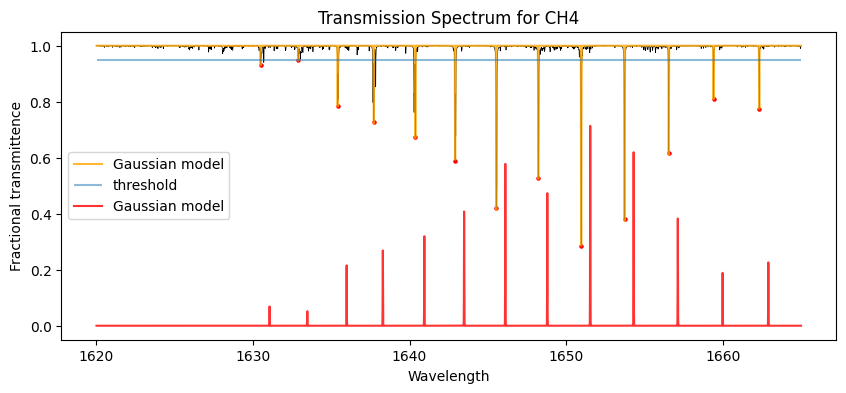

In [12]:
subset = data[index,:]
subset[:,0] = subset[:,0] * 1e3 # Convert wavelength to nm

# Plot original spectrum
plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5)

# Plot the simulated FBG
threshold_value = 0.95
peaks = locate_peaks(subset[:, 1], threshold=threshold_value, distance=100) # distance=100 correspond to 1nm
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, 0, n=10000, sigma=1e-2, type='Gaussian')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.hlines(threshold_value, subset[:, 0].min(), subset[:, 0].max(), alpha=0.5, label='threshold')

# Apply strain to the FBG
strain = 500
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain, n=10000, sigma=1e-2, type='Gaussian')
plt.plot(wavelength_gauss, 1-trans_gauss, color='red', alpha=0.8, label='Gaussian model')

plt.xlabel('Wavelength'); plt.ylabel('Fractional transmittence'); 
plt.title('Transmission Spectrum for CH4')
plt.legend()
plt.show()


Re-define function generate_spectrum_strain to include tension tuning.

Since we have $\Delta \lambda / \lambda \sim 7*10^{-1} \sigma$, where $\sigma$ is in unit of micro-strain ($\mu\epsilon$),

then, we can have $\lambda_{new} \sim (1 + 7*10^{-7} * \sigma) * \lambda$. Now, $\sigma$ is in unit of strain ($\epsilon$).

Below we are applying a range of different strains to the FBG and calculate the cross correlation.

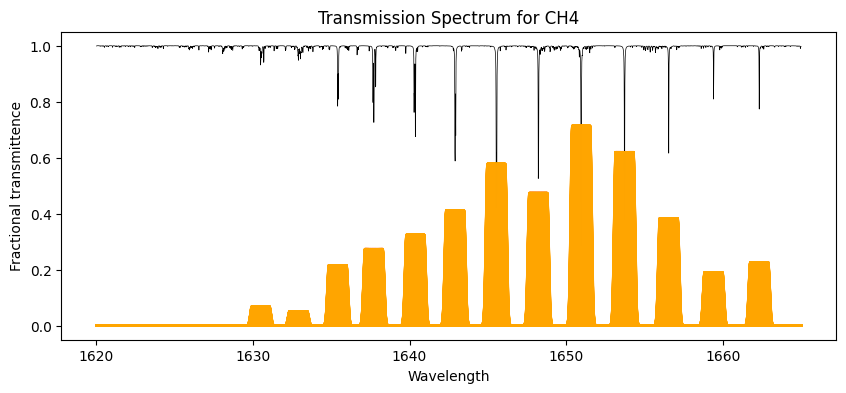

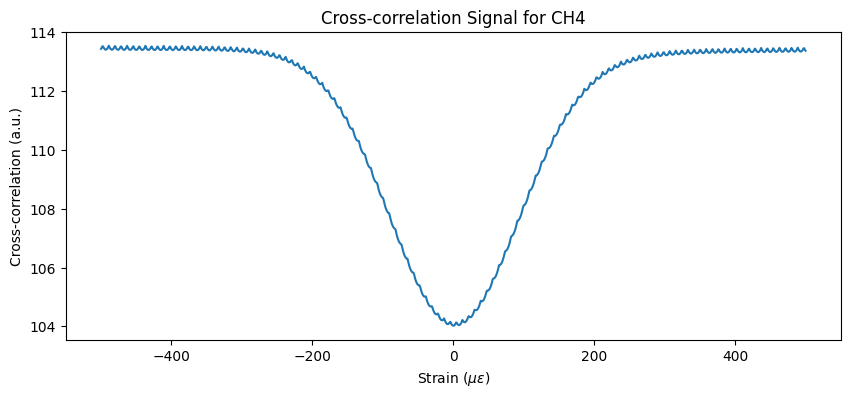

In [14]:
step = 1001
strain = np.linspace(-500, 500, step)
cross_correlation = np.zeros(step)

plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
for i in range(len(strain)): 
    wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain[i], n=len(index), sigma=1e-1, type='Gaussian')
    cross_correlation[i] = np.sum(np.multiply((1-trans_gauss), subset[:,1]))
    plt.plot(wavelength_gauss, 1-trans_gauss, '-', color='orange', alpha=0.8, label='Gaussian model')
plt.xlabel('Wavelength'); plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(strain, cross_correlation)
plt.xlabel('Strain ($\mu\epsilon$)'); plt.ylabel('Cross-correlation (a.u.)')
plt.title('Cross-correlation Signal for CH4')
plt.show()

The ripples in the cross-correlation signal are caused by the cut-off numerical precision when simulating the FBGs (the peak of each Gaussian is not smooth).